In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
initial_df = pd.read_csv('https://raw.githubusercontent.com/artificialflesh/training_projects/master/05_features_n_models/04_athletes.csv')

In [3]:
initial_df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


Поскольку предсказывать будем признак пола, оставим только те данные, которые в этом могут помочь

In [4]:
columns = ['nationality', 'sex', 'height', 'weight', 'sport']

In [5]:
df = initial_df[columns]
df.head()

,nationality,sex,height,weight,sport
0,ESP,male,1.72,64.0,athletics
1,KOR,female,1.68,56.0,fencing
2,CAN,male,1.98,79.0,athletics
3,MDA,male,1.83,80.0,taekwondo
4,NZL,male,1.81,71.0,cycling


Посмотрим, нет ли странных значений в данных и узнаем, есть ли выбросы

In [6]:
for column in columns:
    print(f'{column}: {sorted(list(df[column].unique()))}')

nationality: ['AFG', 'ALB', 'ALG', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ARU', 'ASA', 'AUS', 'AUT', 'AZE', 'BAH', 'BAN', 'BAR', 'BDI', 'BEL', 'BEN', 'BER', 'BHU', 'BIH', 'BIZ', 'BLR', 'BOL', 'BOT', 'BRA', 'BRN', 'BRU', 'BUL', 'BUR', 'CAF', 'CAM', 'CAN', 'CAY', 'CGO', 'CHA', 'CHI', 'CHN', 'CIV', 'CMR', 'COD', 'COK', 'COL', 'COM', 'CPV', 'CRC', 'CRO', 'CUB', 'CYP', 'CZE', 'DEN', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'ERI', 'ESA', 'ESP', 'EST', 'ETH', 'FIJ', 'FIN', 'FRA', 'FSM', 'GAB', 'GAM', 'GBR', 'GBS', 'GEO', 'GEQ', 'GER', 'GHA', 'GRE', 'GRN', 'GUA', 'GUI', 'GUM', 'GUY', 'HAI', 'HKG', 'HON', 'HUN', 'INA', 'IND', 'IOA', 'IRI', 'IRL', 'IRQ', 'ISL', 'ISR', 'ISV', 'ITA', 'IVB', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KIR', 'KOR', 'KOS', 'KSA', 'LAO', 'LAT', 'LBA', 'LBR', 'LCA', 'LES', 'LIB', 'LIE', 'LTU', 'LUX', 'MAD', 'MAR', 'MAS', 'MAW', 'MDA', 'MDV', 'MEX', 'MGL', 'MHL', 'MKD', 'MLI', 'MLT', 'MNE', 'MON', 'MOZ', 'MRI', 'MTN', 'MYA', 'NAM', 'NCA', 'NED', 'NEP', 'NGR', 'NIG', 'NOR', 'NRU',

In [7]:
def outliers(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    check = df[~df[column].between(lower_bound, upper_bound, inclusive='both')]
    count = check[column].count()
    min_ = check[column].min()
    max_ = check[column].max()
    return f'{column} outliers - {count}, min - {min_}, max - {max_}, ' \
            f'lower bound - {lower_bound:.2f}, upper bound - {upper_bound:.2f}'

In [8]:
columns_for_outliers = ['height', 'weight']

In [9]:
list(map(outliers, columns_for_outliers))

['height outliers - 92, min - 1.21, max - 2.21, lower bound - 1.46, upper bound - 2.07',
 'weight outliers - 224, min - 113.0, max - 170.0, lower bound - 28.50, upper bound - 112.50']

In [10]:
df['dob'] = initial_df['dob']

C:\Users\m3thk\AppData\Local\Temp\ipykernel_11816\1622008012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dob'] = initial_df['dob']


In [11]:
df[df['height'].between(1.21, 1.46, inclusive='both')]

,nationality,sex,height,weight,sport,dob
210,JPN,female,1.46,35.0,gymnastics,9/19/99
1080,FIJ,female,1.37,69.0,weightlifting,2/5/91
1221,JPN,female,1.45,37.0,gymnastics,11/19/95
1907,IND,female,1.45,48.0,weightlifting,8/8/94
2106,CHN,female,1.43,34.0,gymnastics,3/18/96
2139,GBR,female,1.37,43.0,gymnastics,10/24/97
2933,CAF,female,1.33,53.0,athletics,6/7/89
3429,BRA,female,1.33,31.0,gymnastics,9/30/99
3570,BEL,female,1.44,57.0,gymnastics,11/16/91
4121,JPN,female,1.45,48.0,weightlifting,11/18/85


In [12]:
df[df['height'].between(2.07, 2.21, inclusive='both')]

,nationality,sex,height,weight,sport,dob
19,EGY,male,2.10,88.0,volleyball,6/3/89
48,NIG,male,2.07,98.0,taekwondo,12/26/94
250,NGR,male,2.10,102.0,basketball,9/14/87
402,RUS,male,2.10,90.0,volleyball,2/14/85
823,AUS,male,2.07,122.0,basketball,11/28/84
...,...,...,...,...,...,...
9251,FRA,male,2.15,113.0,basketball,6/26/92
10042,SRB,male,2.10,104.0,basketball,12/13/89
10922,SRB,male,2.11,112.0,basketball,8/25/87
11023,ESP,male,2.10,115.0,basketball,5/27/94


In [13]:
df[df['weight'].between(112.50, 170.0, inclusive='both')]

,nationality,sex,height,weight,sport,dob
34,EGY,male,1.76,120.0,wrestling,12/8/95
58,UZB,male,1.90,132.0,judo,3/28/81
75,HUN,male,2.03,115.0,aquatics,2/29/84
83,GEO,male,1.89,130.0,judo,1/1/89
186,EGY,male,1.85,144.0,weightlifting,4/27/88
...,...,...,...,...,...,...
11225,KAZ,male,1.94,120.0,athletics,11/17/84
11298,TUN,female,1.78,120.0,weightlifting,8/31/95
11428,PAN,female,1.75,150.0,athletics,3/16/85
11484,CHN,male,1.88,120.0,wrestling,2/1/88


В целом значения допустимые с учетом видов спорта. Есть определенно выделяющиеся значения, но не невозможные. Люди с низким ростом могут быть еще и не взрослыми, но у нас есть только дата рождения, а она не особо помогает разобраться с возрастом людей, поскольку неизвестно в каком году собраны данные.

Теперь вернем только нужные столбцы и проверим данные на пропуски

In [14]:
df = df[columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nationality  11538 non-null  object 
 1   sex          11538 non-null  object 
 2   height       11208 non-null  float64
 3   weight       10879 non-null  float64
 4   sport        11538 non-null  object 
dtypes: float64(2), object(3)
memory usage: 450.8+ KB


In [16]:
df.isna().sum()

nationality      0
sex              0
height         330
weight         659
sport            0
dtype: int64

Принято решение от пропусков просто избавиться

In [17]:
df = df[~(df['height'].isna())]
df = df[~(df['weight'].isna())]

In [18]:
df

,nationality,sex,height,weight,sport
0,ESP,male,1.72,64.0,athletics
1,KOR,female,1.68,56.0,fencing
2,CAN,male,1.98,79.0,athletics
3,MDA,male,1.83,80.0,taekwondo
4,NZL,male,1.81,71.0,cycling
...,...,...,...,...,...
11533,CUB,female,1.64,58.0,athletics
11534,CZE,female,1.73,63.0,athletics
11535,CHN,male,1.85,100.0,wrestling
11536,VIE,male,1.60,56.0,weightlifting


Преобразуем категориальные признаки

In [19]:
categorical_features = ['nationality', 'sport']

In [20]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [21]:
df.head()

,sex,height,weight,nationality_ALB,nationality_ALG,nationality_AND,nationality_ANG,nationality_ANT,nationality_ARG,nationality_ARM,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,male,1.72,64.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,female,1.68,56.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,male,1.98,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,male,1.83,80.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,male,1.81,71.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X = df.drop('sex', axis=1)

In [23]:
le = LabelEncoder()
le.fit(df['sex'])
y = pd.Series(data=le.transform(df['sex']))

In [24]:
y.value_counts()

1    5862
0    4996
dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model = LogisticRegression(max_iter=10000)

In [27]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [28]:
model.score(X_train, y_train)

0.845383375546857

In [29]:
model.score(X_test, y_test)

0.83195211786372

Построим ROC-кривую (Receiver Operating Characteristic) с помощью функции sklearn.metrics.roc_curve

In [30]:
predictions_prob = model.predict_proba(X_test)

In [31]:
fpr, tpr, thres = roc_curve(y_test, predictions_prob[:, 1])

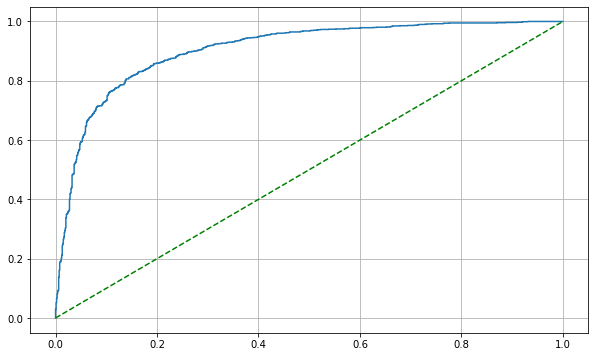

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.grid()

Вычислим значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score

In [33]:
roc_auc_score(y_test, predictions_prob[:, 1])

0.9050656463004024

Реализуем подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn

In [34]:
def confusion_matrix(predictions, actual_data, threshold=0.5):
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for predicted_prob, actual in zip(predictions[:, 1], actual_data):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
                
    return tp, fp, fn, tn

In [35]:
tp, fp, fn, tn = confusion_matrix(predictions_prob, y_test)

In [36]:
tp / (tp + fn) # tpr

0.8484848484848485

In [37]:
fp / (fp + tn) # fpr

0.18800813008130082

In [38]:
def true_false_rate(predictions, actual_data):
    append_first_el = np.append(predictions[:, 1], 1)
    unique = np.unique(append_first_el)
    thresholds = np.sort(unique, kind='quicksort')[::-1]
    
    tpr = []
    fpr = []
    precision = []

    for thr in thresholds:
        tp, fp, fn, tn = confusion_matrix(predictions, actual_data, thr)
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        
    return tpr, fpr, precision, thresholds

In [39]:
tpr_manual, fpr_manual, precision, thresholds = true_false_rate(predictions_prob, y_test)

Построим ROC-кривую с помощью вычисленных метрик и сравним с предыдущим таким графиком

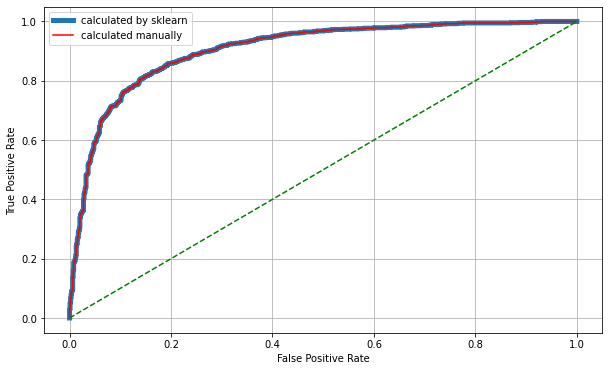

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=5, label='calculated by sklearn' )
plt.plot(fpr_manual, tpr_manual, color='red', label='calculated manually')
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)
plt.grid()
plt.show()

Графики совпадают

Построим график Precision-Recall, используя посчитанные метрики

In [41]:
pr, re, thres = precision_recall_curve(y_test, predictions_prob[:, 1])

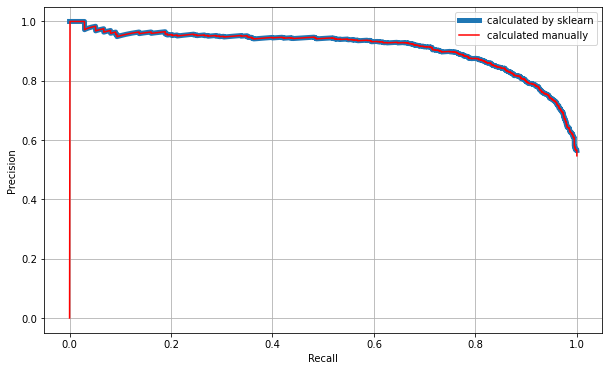

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(re, pr, linewidth=5, label='calculated by sklearn' )
plt.plot(tpr_manual, precision, color='red', label='calculated manually')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc=0)
plt.grid()
plt.show()

Графики отличаются начальными и конечными точками, в остальных совпадают

Вычислите значение ROC-AUC, используя посчитанные метрики

In [43]:
def roc_auc(tpr, fpr, thresholds):
    auc = int()
    for i in range(len(thresholds) - 1):
        auc += (tpr[i+1] + tpr[i]) * (fpr[i+1] - fpr[i]) / 2
    return auc

In [44]:
roc_auc(tpr_manual, fpr_manual, thresholds)

0.905065646300407

Сравним со значением ROC-AUC, посчитанным через sklearn

In [45]:
roc_auc_score(y_test, predictions_prob[:, 1])

0.9050656463004024

Результат очень близок к посчитанному вручную

Выводы:

Чем ближе ROC-кривая к левому верхнему углу, тем лучше качество модели. Обученная модель, конечно, не идеальная, но график показывает высокий уровень качества по этой метрике.

В случае с графиком Precision-Recall нас интересует противоположная точка — (1, 1), через которую будет проходить кривая в случае 100% точности и полноты в идеальном случае. Результаты обученной модели имеют высокую полноту и относительно высокую точность.

Я не смог подобрать данные так, чтобы кривая ушла под диагональ и не представляю, что ее может туда загнать, поэтому вопрос остался открытым

Есть и еще один вопрос, касающихся пороговых значений, отсечек

In [46]:
# в массиве предсказанных вероятностей содержится 2172 значения
len(predictions_prob[:, 1])

2172

In [47]:
# из них уникальных 2159
len(np.unique(predictions_prob[:, 1]))

2159

In [48]:
# при указании drop_intermediate=False пороговых значений остается столько же и +1
fpr, tpr, thres = roc_curve(y_test, predictions_prob[:, 1], drop_intermediate=False)
len(thres)

2160

In [49]:
# но при значении параметра drop_intermediate=True пороговых значений уже 547
fpr, tpr, thres = roc_curve(y_test, predictions_prob[:, 1])
len(thres)

547

Как именно roc_curve в sklearn определяет, какие пороговые значения являются неоптимальными? По какому принципу?